<a href="https://colab.research.google.com/github/from-iqwerty-import-IQ/Deep_Learning_Projects/blob/main/Copy_of_Handwritten_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d landlord/handwriting-recognition

 99% 1.25G/1.26G [00:07<00:00, 174MB/s]
100% 1.26G/1.26G [00:07<00:00, 174MB/s]


In [3]:
!unzip '/content/handwriting-recognition.zip' &> /dev/null

### Importing all the libraries

In [1]:
!pip install np_utils  &> /dev/null

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout,Input,Reshape,Bidirectional,LSTM,Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [3]:
dir = "/content/train_v2"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])




In [4]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')

In [8]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


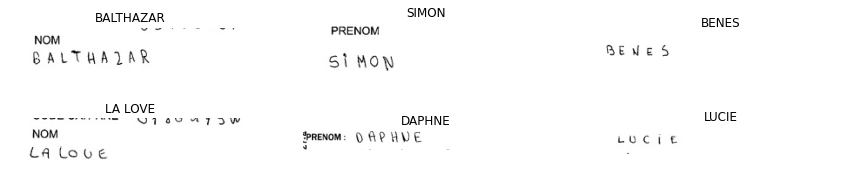

In [9]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train_v2/train/'+train.loc[i, 'FILENAME']
    #img_dir =''
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [5]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [6]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

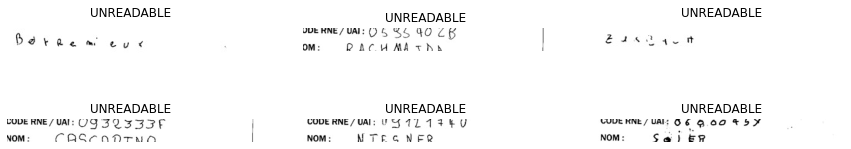

In [12]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [8]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [9]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [10]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [11]:
train_x = []
train_size = 60000

for i in range(train_size):
    img_dir = '/content/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [12]:
valid_size = 10000

In [13]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [14]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [15]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [16]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [17]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1]) 
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])] = label_to_num(train.loc[i, 'IDENTITY'])  


In [18]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])  

In [19]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [20]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [21]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [22]:
filepath = '/content/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.h5'

In [23]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=64,callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
938/938 [==============================] - 117s 99ms/step - loss: 22.1274 - val_loss: 19.6245

Epoch 00001: val_loss improved from inf to 19.62455, saving model to /content/my_best_model.epoch01-loss19.62.h5
Epoch 2/60
938/938 [==============================] - 90s 96ms/step - loss: 18.4413 - val_loss: 16.2823

Epoch 00002: val_loss improved from 19.62455 to 16.28232, saving model to /content/my_best_model.epoch02-loss16.28.h5
Epoch 3/60
938/938 [==============================] - 90s 96ms/step - loss: 13.1449 - val_loss: 17.1763

Epoch 00003: val_loss did not improve from 16.28232
Epoch 4/60
938/938 [==============================] - 90s 96ms/step - loss: 7.5923 - val_loss: 5.7809

Epoch 00004: val_loss improved from 16.28232 to 5.78095, saving model to /content/my_best_model.epoch04-loss5.78.h5
Epoch 5/60
938/938 [==============================] - 90s 96ms/step - loss: 5.0293 - val_loss: 3.9250

Epoch 00005: val_loss improved from 5.78095 to 3.92501, saving model to /conten

In [29]:
model.save("/content/final_model.h5")

In [26]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [27]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 85.88%
Correct words predicted      : 74.34%


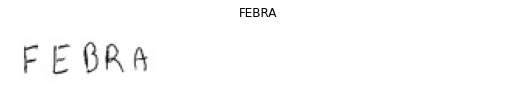

In [66]:
plt.figure(figsize=(9, 7))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/content/test_v2/test/TEST_1036.jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

In [74]:
!wget "https://i.ytimg.com/vi/5qyHCdM5XNw/maxresdefault.jpg"

--2021-09-26 13:23:45--  https://i.ytimg.com/vi/5qyHCdM5XNw/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 142.250.107.119, 74.125.135.119, 74.125.142.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|142.250.107.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175899 (172K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[===================>] 171.78K  --.-KB/s    in 0.002s  

2021-09-26 13:23:45 (91.7 MB/s) - ‘maxresdefault.jpg’ saved [175899/175899]



/content/maxresdefault.jpg


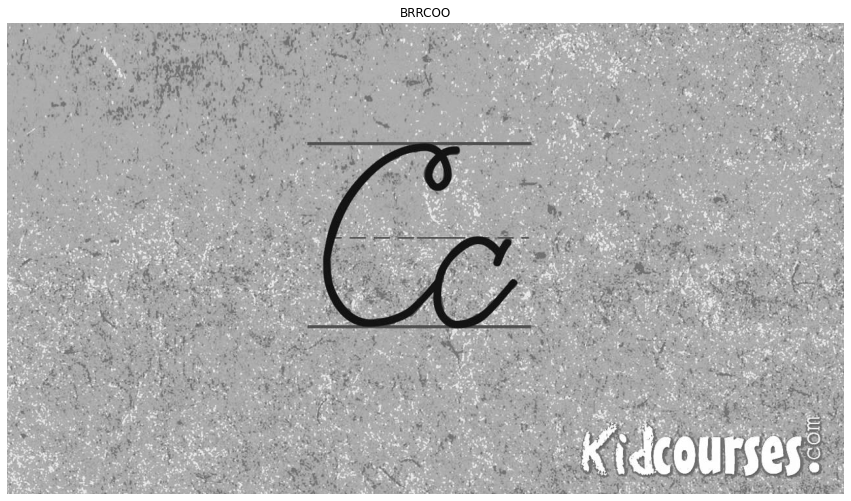

In [75]:
test = pd.read_csv('/content/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))

img_dir = str(input())
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
    
image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

/content/Images/IMAGE 2021-09-26 18:45:11.jpg


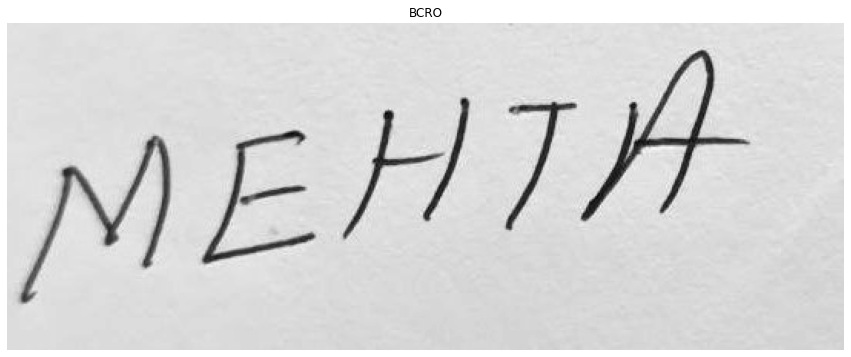

In [76]:
test = pd.read_csv('/content/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))

img_dir = str(input())
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
    
image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
!kaggle datasets download -d tejasreddy/iam-handwriting-top50

 94% 175M/187M [00:01<00:00, 152MB/s]
100% 187M/187M [00:01<00:00, 155MB/s]


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!unzip '/content/iam-handwriting-top50.zip' &> /dev/null

/content/Images/IMAGE 2021-09-26 18:45:07.jpg


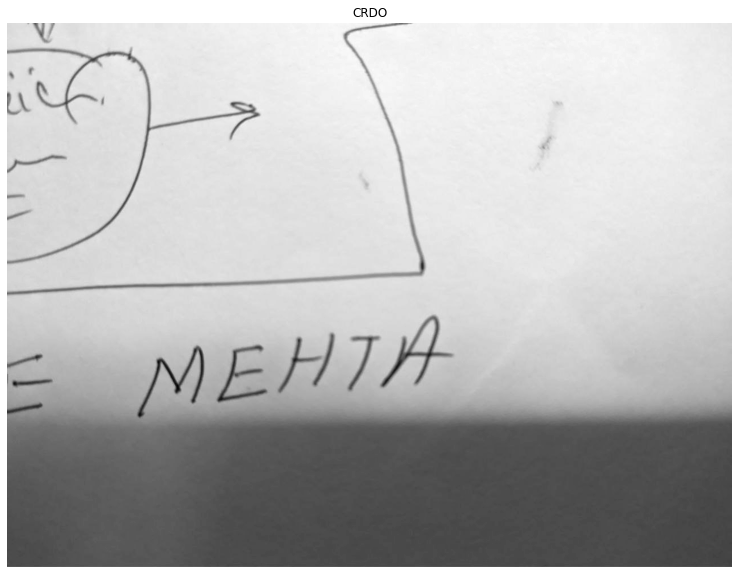

In [ ]:
test = pd.read_csv('/content/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))

img_dir = str(input())
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
    
image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
!kaggle datasets download -d tejasreddy/iam-handwriting-top50

 94% 175M/187M [00:01<00:00, 152MB/s]
100% 187M/187M [00:01<00:00, 155MB/s]


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!unzip '/content/iam-handwriting-top50.zip' &> /dev/null